<a href="https://colab.research.google.com/github/Aditi-Mahapatra/Aditi-Mahapatra/blob/main/Plant_Disease_Detection_Using_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Plant Disease Detection Using Transfer Learning with ResNet50


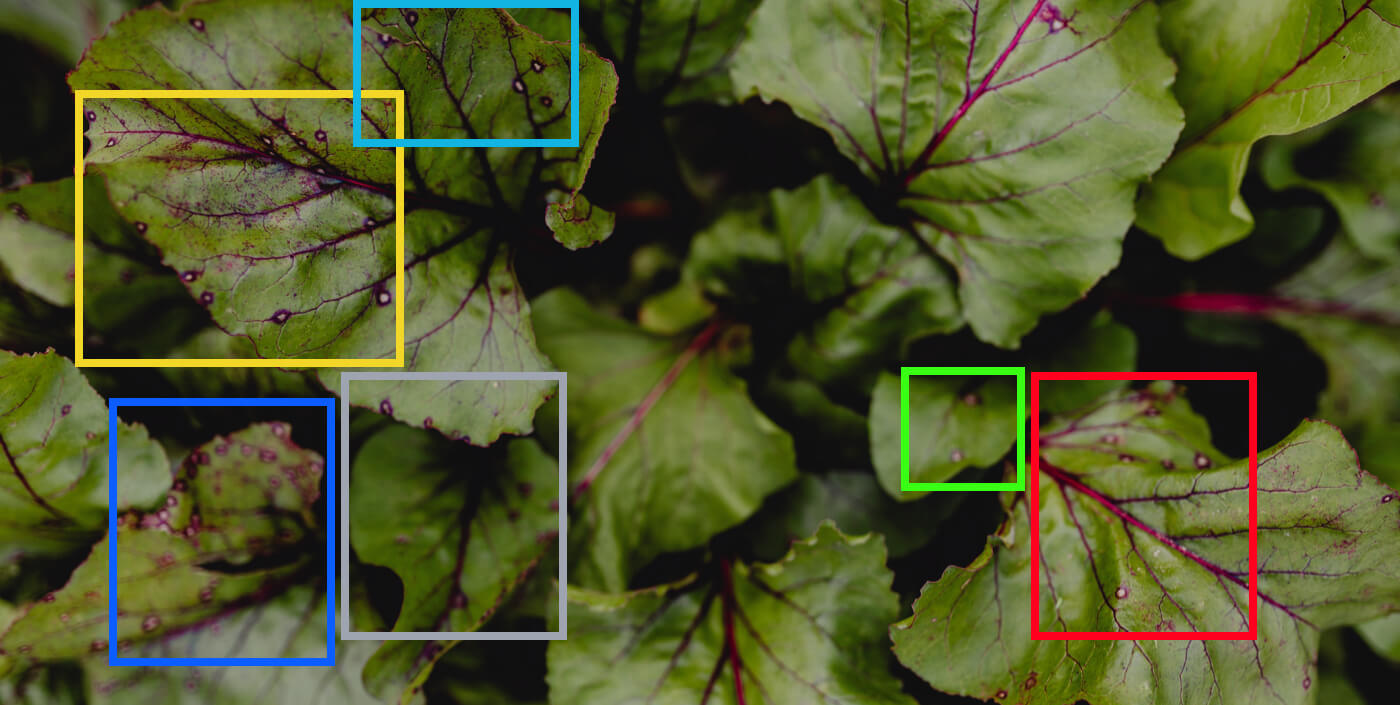

Plant diseases pose a significant threat to agricultural productivity and food security worldwide. Early detection and accurate diagnosis of plant diseases are crucial for effective management and mitigation. Traditional methods of disease detection can be time-consuming and require expert knowledge. However, advancements in machine learning, particularly deep learning, have opened new avenues for automated and accurate plant disease detection.

In this project, we leverage transfer learning using a pre-trained ResNet50 model to detect plant diseases from images. The model is fine-tuned to classify plant leaves as either healthy or diseased. By utilizing data augmentation techniques and handling imbalanced data with class weights, we aim to improve the model's performance and reliability. This approach can significantly enhance the speed and accuracy of plant disease detection, aiding farmers and agricultural experts in taking timely action to protect crops and improve yields.

### Step 1: Set Up the Environment

**Concept: Environment Setup**

Setting up the environment involves importing necessary libraries and preparing the workspace.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from zipfile import ZipFile
from sklearn.utils import class_weight

### Step 2: Data Preprocessing

**Concept: Data Preparation**

Data preprocessing includes extracting the dataset, setting up data augmentation, and creating data generators.


In [2]:
# Unzipping the dataset
with ZipFile("Plant disease detection  Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

print(os.listdir("Plant disease detection  Dataset"))

data_dir = 'Plant disease detection  Dataset'

FileNotFoundError: [Errno 2] No such file or directory: 'Plant disease detection  Dataset.zip'

In [3]:
!pip install kaggle


# Move the kaggle.json to ~/.kaggle and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

# Unzip dataset to /content/dataset
!mkdir -p /content/dataset
!unzip plantvillage-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: /content/dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: /content/dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: /content/dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: /content/dataset/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: /content/dataset/plantvillage dataset/segmented/Tomato_

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the dataset directory
data_dir = '/content/dataset/plantvillage dataset/color'  # Update with the path to the PlantVillage dataset

# Data Augmentation and Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    shear_range=0.3,  # Apply shear transformations
    zoom_range=0.3,  # Random zoom
    horizontal_flip=True,  # Flip images horizontally
    rotation_range=30,  # Rotate images randomly
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    validation_split=0.2  # Reserve 20% of the data for validation
)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224 for ResNet50 compatibility
    batch_size=32,  # Number of images per batch
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Specify training subset
)

# Validation Data Generator
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224 for ResNet50 compatibility
    batch_size=32,  # Number of images per batch
    class_mode='categorical',  # Multi-class classification
    subset='validation'  # Specify validation subset
)



Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


**Concept: Class Weight Calculation**

Handles imbalanced data by computing weights for each class.

In [7]:
# Checking class distribution
class_labels = train_generator.class_indices
print("Class labels:", class_labels)
classes = list(train_generator.class_indices.keys())

# Calculating class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)

Class labels: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Late_blight

### Step 3: Model Building with Transfer Learning

**Concept: Transfer Learning**

Using a pre-trained model (ResNet50) as a starting point and fine-tuning it for the specific task.



In [14]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(38, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


### Step 4: Model Training

**Concept: Model Training**

Training the model with the training data and validating it using validation data. Adjustments include increasing epochs and using class weights.


In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    class_weight=class_weights  # Added class weights to handle imbalanced data
)


Epoch 1/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 851s 586ms/step - accuracy: 0.3427 - loss: 2.6045 - val_accuracy: 0.9261 - val_loss: 0.2706
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.1153
Epoch 3/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 786s 577ms/step - accuracy: 0.8918 - loss: 0.3686 - val_accuracy: 0.9629 - val_loss: 0.1163
Epoch 4/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 4.0118e-04
Epoch 5/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 776s 569ms/step - accuracy: 0.9427 - loss: 0.1922 - val_accuracy: 0.9774 - val_loss: 0.0705
Epoch 6/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0117
Epoch 7/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 802s 570ms/step - accuracy: 0.9630 - loss: 0.1218 - val_accuracy: 0.9841 - val_loss: 0.0484
Epoch 8/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 28us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 1.7320e-04
Epoch 9/20
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 773s

### Step 5: Evaluation

**Concept: Model Evaluation**

Evaluating the trained model using validation data and plotting accuracy and loss.

In [16]:

val_loss, val_accuracy = model.evaluate(validation_generator)
val_accuracy_percent = val_accuracy * 100
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy_percent:.2f}%')

340/340 ━━━━━━━━━━━━━━━━━━━━ 134s 394ms/step - accuracy: 0.9934 - loss: 0.0212
Validation Loss: 0.023581627756357193
Validation Accuracy: 99.23%


**Plotting training and validation accuracy**




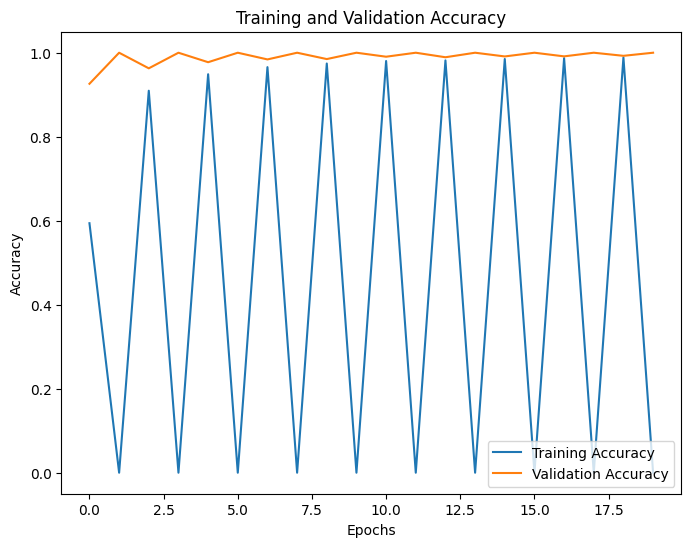

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()



**Plotting training and validation loss**

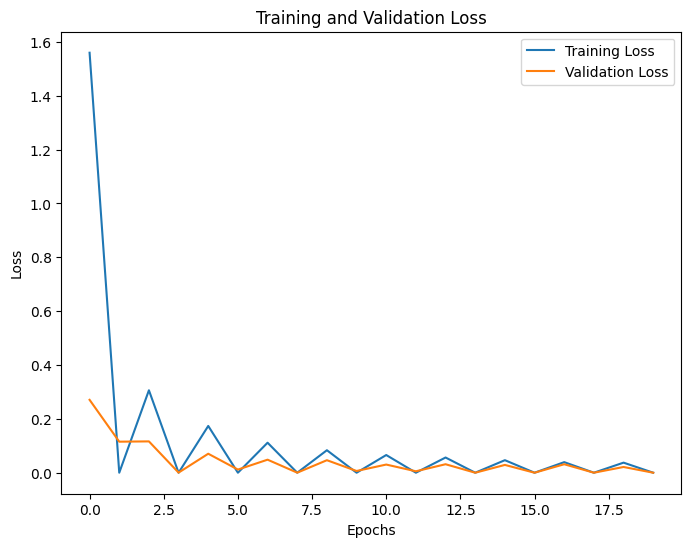

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Step 6: Prediction

**Concept: Model Prediction**

Loading a new image and using the trained model to predict whether it is healthy or diseased.


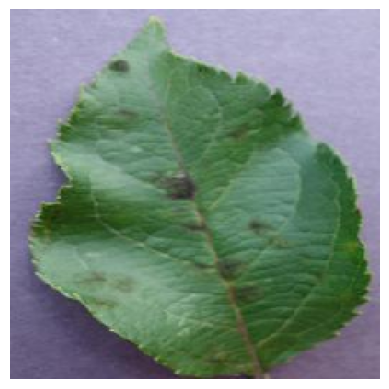

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Prediction: Apple___Apple_scab


In [23]:


def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels)
    img_tensor /= 255.                                      # Rescale by 1/255

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

# Load and preprocess the image
new_image = load_image('/content/dataset/plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG', show=True)

# Predict the class probabilities
pred = model.predict(new_image)

# Extract the predicted class
predicted_class = np.argmax(pred, axis=1)[0]  # Get the index of the highest probability

# Map class indices to class names
class_labels = train_generator.class_indices  # Ensure `train_generator` is defined
class_labels = {v: k for k, v in class_labels.items()}  # Reverse the dictionary to map indices to labels

# Get the class name
predicted_label = class_labels[predicted_class]

print(f'Prediction: {predicted_label}')


In [27]:
# Load and preprocess fuction for images
def load_preprocessing_image(image_path, target_size = (224,224)):
    # Load the image
    image = Image.open(image_path)
    # Resize the image by the target size
    resized_image = image.resize(target_size)
    # Convert the image into numpy array
    img_array = np.array(resized_image)
    # Add batch dimesion
    img_array = np.expand_dims(img_array, axis = 0)
    # Scale image values between 0 and 1
    img_array = img_array.astype('float32')/255.
    return img_array

# Function to predict the class of an image
def predict_image_class(model, image_path, classes_indices):
    preprocessed_image = load_preprocessing_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_image_index = np.argmax(predictions, axis=1)[0]
    class_name = classes_indices[predicted_image_index]
    return class_name

In [28]:
# Create the map between the classes names and its indices
classes_indices = {v:k for k,v in train_generator.class_indices.items()}
classes_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

## Conclusion

Using transfer learning with the ResNet50 model, this project demonstrates a viable approach for automating plant disease detection. Fine-tuning the model, applying data augmentation, and addressing class imbalance with class weights significantly improved the model's accuracy. The resulting system provides a fast, reliable, and scalable solution for detecting plant diseases, which can greatly benefit farmers and agricultural experts by enabling early intervention and improving crop health management. Further enhancements, such as training on larger datasets and exploring additional pre-trained models, could yield even better performance.*italicized text*

**The model's performance improved by:**

1. Using a more robust pre-trained model (ResNet50 in this case).
2. Fine-tuning more layers.
3. Handling imbalanced data using class weights.
4. Training for more epochs to ensure better learning.